In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [48]:
## define some numbers
Number_para = 20
obs_N = 15
number_burnin = 1000
number_sample = 2000
steps_gradient_decent = 50

In [49]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

In [50]:
pi = constant64(m.pi) # define PI in Tensorflow form

In [51]:
depth = constant64(-60)
thickness = constant64(20)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [247]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(x,z,loc):

    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = constant64(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(x,z):

    thick = thickness

    x_obv = tf.linspace(constant64(-70.),constant64(70.),obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float64, size=obv.shape[0])

    j = tf.constant(0)
    for i in obv:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return tf.reshape(gravity.stack(),shape = [obs_N])



def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

Define the Prior and likelihood distribution

In [110]:
# prior
mu_prior = -60.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 10.*tf.eye(Number_para,dtype = tf.float64)

# likelihood
sig_e = constant64(0.0000001)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [196]:
tf.random.set_seed(8)
control_position = tf.random.normal([Number_para],depth,7,dtype = tf.float64)
control_index = tf.linspace(constant64(-70),constant64(70),Number_para)

M = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(constant64(-150),constant64(-80),M),depth*tf.ones(M,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(constant64(80),constant64(150),M),depth*tf.ones(M,dtype = tf.float64)]))


def GaussianProcess_model(_control_index,_control_position,visual = False,resolution = None):
    if resolution is None:
        resolution=3
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+2*M,1])
    amplitude = tfp.util.TransformedVariable(
      10, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      1000, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-50), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry
    if visual == True:
        visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],200),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    
    if visual == True:
        gprm_visual = tfd.GaussianProcessRegressionModel(
            kernel=kernel,
            index_points=visual_index,
            observation_index_points=observation_index_points,
            observations=points[:,1],
            observation_noise_variance=observation_noise_variance)
        tf.random.set_seed(1)
        visual_position = gprm_visual.sample(1,seed =1)
        plt.figure(figsize = (14,7))
        plt.scatter(_control_index,_control_position,c = 'r')
        plt.plot(tf.transpose(visual_index).numpy()[0],visual_position[0])
        
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[1]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete



In [199]:
def GaussianProcess_model_plot(control_index,control_position,ax = None,resolution = None,**args):
    if resolution is None:
        resolution=3
    if ax is None:
        f,ax = plt.subplots()
        
    points = tf.stack([control_index,control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+2*M,1])
    amplitude = tfp.util.TransformedVariable(
      10, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      100, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-500), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry

    visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],100),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    

    gprm_visual = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=visual_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    visual_position = gprm_visual.sample(1,seed =1)
    ax.scatter(control_index,control_position,c = 'r',**args)
    ax.plot(tf.transpose(visual_index).numpy()[0],visual_position[0],'b',**args)
    
    return 

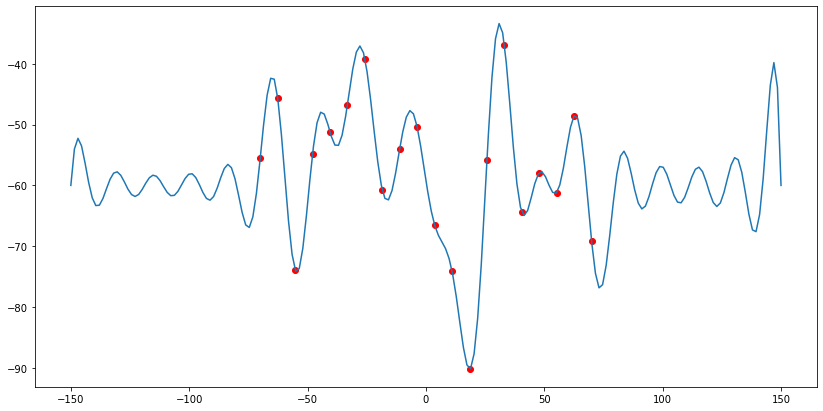

In [212]:
## generate some true observation gravity data

True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)

x_true,z_true = GaussianProcess_model(control_index,True_position,visual =True,resolution=4)
D = grav(x_true,z_true)

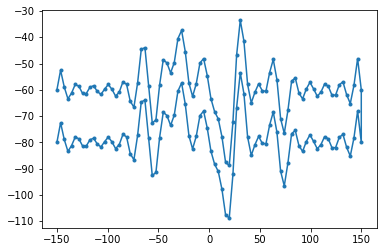

In [201]:
plt.plot(x_true,z_true,'.-')

In [202]:
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

#### create some noise

In [203]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =constant64(0),stddev =sig_e,seed = 1,dtype = tf.float64)

In [215]:
D_noise = D+noise

In [235]:
def grav_calculate(x,z,x_obs=None,Number_=obs_N ,R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(x,z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
#     ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

### Full Gravity response at surface

array([[1.14974477e-05],
       [1.18200987e-05],
       [1.20887205e-05],
       [1.22893789e-05],
       [1.24008224e-05],
       [1.24140867e-05],
       [1.23524108e-05],
       [1.22605530e-05],
       [1.21754402e-05],
       [1.21039116e-05],
       [1.20198504e-05],
       [1.18902763e-05],
       [1.17057104e-05],
       [1.14751297e-05],
       [1.12057363e-05]])

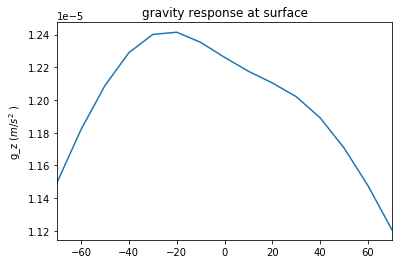

In [206]:
grav_calculate(x_true,z_true)

## Plotting function

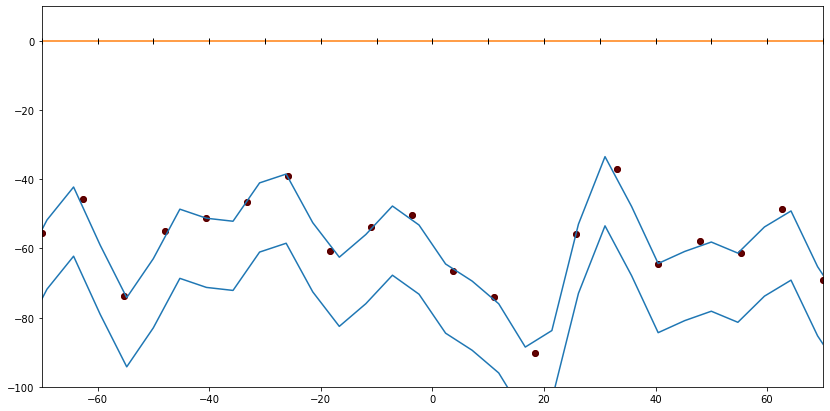

In [221]:
def Draw_inter(_control_index,_control_position,x_true = None,z_true = None,R = 70, ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is None:
        x_true,z_true = GaussianProcess_model(_control_index,_control_position)
    ax.scatter(control_index,_control_position, c = 'red')
    ax.scatter(control_index,True_position, c = 'black',alpha = 0.6)
    ax.plot(x_true,z_true)
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(-100,10)
    ax.set_xlim(-R,R)
Draw_inter(control_index,True_position)

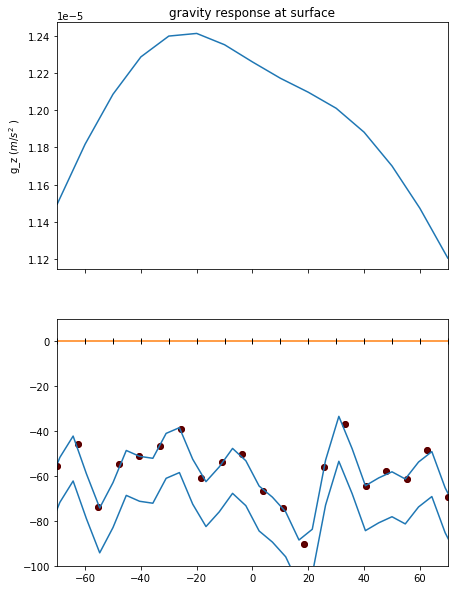

In [232]:
def Draw(_control_index,_control_position,ax = None):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(_control_index,_control_position)
    grav_calculate(_x,_z,ax = ax[0])
    Draw_inter(_control_index,_control_position,ax = ax[1])
Draw(control_index,True_position)

In [237]:
x_obs = np.linspace(-70,70,obs_N)

### Gravity response at receivers

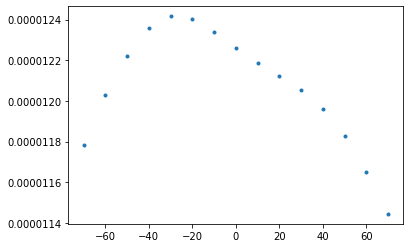

In [239]:
plt.plot(x_obs,D,'.')

#### Gradient decent

In [209]:
mu = tf.random.uniform([Number_para],minval = -50,maxval = -30,seed = 1,dtype = tf.float64) # initial parameters

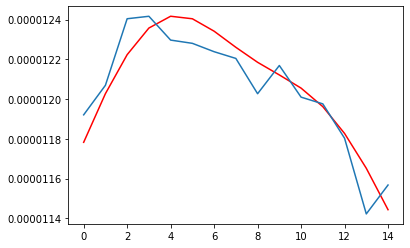

In [216]:
f,ax = plt.subplots()
ax.plot(D,'r')
ax.plot(D_noise)


In [223]:
steps_gradient_decent = 50

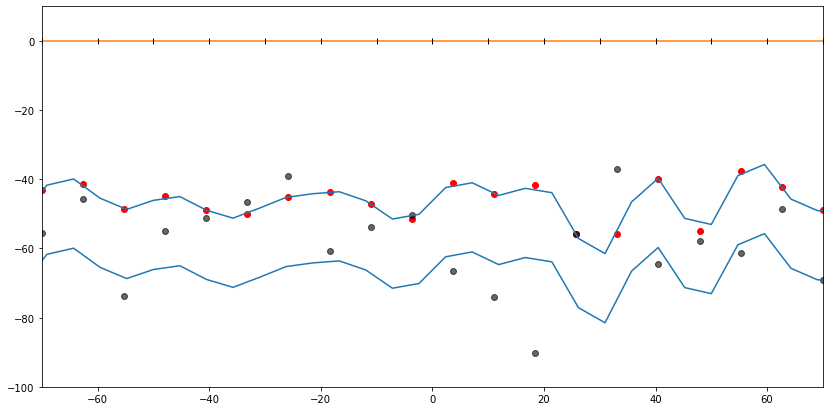

In [224]:
Draw_inter(control_index,mu)

loss tf.Tensor(520.1695250687277, shape=(), dtype=float64)
grad tf.Tensor(
[2.39614498 2.94640125 3.35305636 4.29204724 4.74719221 5.12601831
 6.67741193 7.52992812 7.47752427 7.22269219 9.5426958  9.39681679
 9.53962537 6.62372531 6.11315064 8.79024354 5.11585363 7.29185075
 4.90213842 3.74504454], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.27360225 -41.53662481 -48.81272565 -45.07108086 -49.05180116
 -50.25580488 -45.29877262 -43.91369539 -47.42059321 -51.74320657
 -41.30368464 -44.56625271 -41.9921051  -56.13788877 -56.00997377
 -40.06028897 -55.25809574 -37.9071391  -42.33790205 -48.89513722], shape=(20,), dtype=float64)
Iteration 0


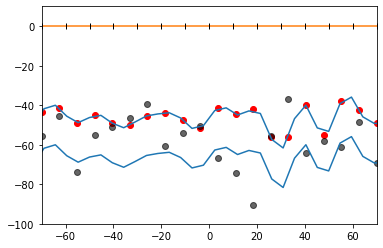

loss tf.Tensor(495.1970568133761, shape=(), dtype=float64)
grad tf.Tensor(
[2.39766497 2.90670288 3.31855618 4.20192043 4.66569024 4.9970435
 6.53574283 7.34373364 7.29542493 7.03314369 9.30047624 9.16142884
 9.29645007 6.46397083 5.9459915  8.6194422  4.98396757 7.18680237
 4.8186776  3.70617281], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.3455322  -41.62382589 -48.91228233 -45.19713847 -49.19177186
 -50.40571619 -45.4948449  -44.1340074  -47.63945596 -51.95420088
 -41.58269893 -44.84109557 -42.2709986  -56.33180789 -56.18835351
 -40.31887223 -55.40761477 -38.12274317 -42.48246238 -49.0063224 ], shape=(20,), dtype=float64)
Iteration 1


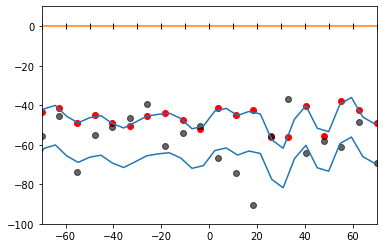

loss tf.Tensor(471.03092862657263, shape=(), dtype=float64)
grad tf.Tensor(
[2.37769322 2.89177897 3.25515423 4.13894922 4.55986102 4.89089094
 6.38002652 7.17375535 7.11106218 6.850485   9.06892828 8.92572156
 9.07244199 6.29252466 5.80257028 8.43016113 4.87814547 7.05841112
 4.75706302 3.65065674], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.41686299 -41.71057926 -49.00993696 -45.32130695 -49.32856769
 -50.55244291 -45.6862457  -44.34922006 -47.85278782 -52.15971543
 -41.85476678 -45.10886722 -42.54317186 -56.52058363 -56.36243062
 -40.57177707 -55.55395913 -38.33449551 -42.62517427 -49.1158421 ], shape=(20,), dtype=float64)
Iteration 2


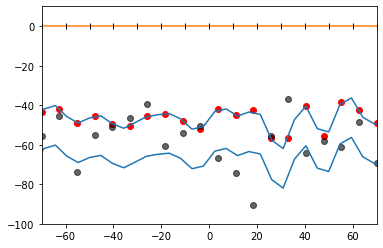

loss tf.Tensor(448.09158199454214, shape=(), dtype=float64)
grad tf.Tensor(
[2.36358962 2.86951608 3.20138978 4.07004413 4.46447849 4.78227964
 6.23471797 7.00658384 6.93587777 6.67420837 8.84609291 8.70165071
 8.85429301 6.13209914 5.65921647 8.2542714  4.76962748 6.94108397
 4.69145251 3.60122041], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.48777068 -41.79666475 -49.10597865 -45.44340827 -49.46250205
 -50.6959113  -45.87328724 -44.55941757 -48.06086416 -52.35994168
 -42.12014957 -45.36991674 -42.80880065 -56.70454661 -56.53220712
 -40.81940521 -55.69704796 -38.54272803 -42.76591784 -49.22387871], shape=(20,), dtype=float64)
Iteration 3


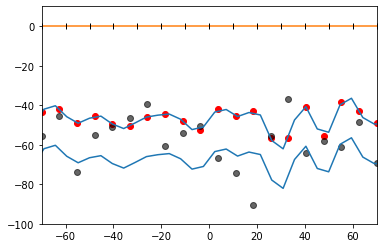

loss tf.Tensor(426.1614985913933, shape=(), dtype=float64)
grad tf.Tensor(
[2.35570165 2.83980081 3.15761    3.99471186 4.37939142 4.67052318
 6.09892733 6.84128192 6.76835039 6.50338445 8.62971729 8.48782705
 8.63975119 5.98160241 5.51404069 8.0905962  4.6568226  6.83424641
 4.62045593 3.55793206], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.55844173 -41.88185877 -49.20070695 -45.56324963 -49.59388379
 -50.836027   -46.05625506 -44.76465603 -48.26391467 -52.55504321
 -42.37904109 -45.62455155 -43.06799319 -56.88399468 -56.69762834
 -41.06212309 -55.83675263 -38.74775542 -42.90453152 -49.33061668], shape=(20,), dtype=float64)
Iteration 4


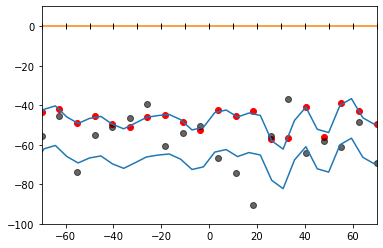

loss tf.Tensor(405.17649710556736, shape=(), dtype=float64)
grad tf.Tensor(
[2.34261733 2.81586795 3.10775478 3.92689906 4.29044625 4.56643375
 5.96323549 6.68379832 6.60480356 6.33859984 8.42200222 8.27993035
 8.43568149 5.83246378 5.37819191 7.92694915 4.55281989 6.72439681
 4.55600013 3.51148899], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.62872025 -41.96633481 -49.29393959 -45.6810566  -49.72259718
 -50.97302001 -46.23515212 -44.96516998 -48.46205877 -52.74520121
 -42.63170115 -45.87294946 -43.32106363 -57.05896859 -56.85897409
 -41.29993157 -55.97333723 -38.94948732 -43.04121153 -49.43596135], shape=(20,), dtype=float64)
Iteration 5


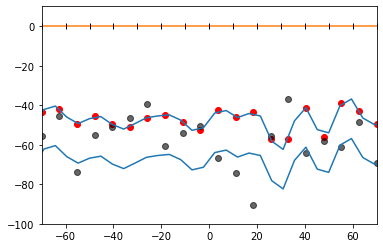

loss tf.Tensor(385.11599091370647, shape=(), dtype=float64)
grad tf.Tensor(
[2.32985376 2.79137375 3.05952548 3.85989232 4.20439713 4.46472337
 5.83205421 6.53103767 6.44682057 6.17928819 8.2215733  8.07963727
 8.23847224 5.68864642 5.24621645 7.76905558 4.45130186 6.61802962
 4.49245004 3.46637253], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.69861587 -42.05007602 -49.38572536 -45.79685337 -49.84872909
 -51.10696171 -46.41011375 -45.16110111 -48.65546339 -52.93057985
 -42.87834835 -46.11533858 -43.5682178  -57.22962798 -57.01636059
 -41.53300324 -56.10687629 -39.14802821 -43.17598503 -49.53995252], shape=(20,), dtype=float64)
Iteration 6


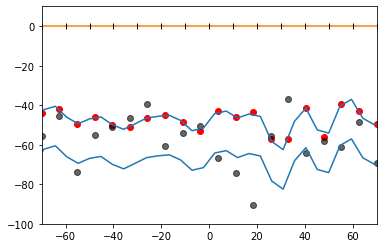

loss tf.Tensor(365.9428126940511, shape=(), dtype=float64)
grad tf.Tensor(
[2.31995313 2.76338271 3.01645153 3.79053082 4.12433951 4.36282356
 5.70738738 6.38136561 6.29509033 6.02495314 8.02772143 7.88743654
 8.04638086 5.55177116 5.11561205 7.6193239  4.34939543 6.51795351
 4.42727571 3.42454946], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.76821446 -42.1329775  -49.4762189  -45.91056929 -49.97245928
 -51.23784642 -46.58133537 -45.35254208 -48.8443161  -53.11132845
 -43.11917999 -46.35196168 -43.80960922 -57.39618112 -57.16982895
 -41.76158295 -56.23735815 -39.34356682 -43.3088033  -49.64268901], shape=(20,), dtype=float64)
Iteration 7


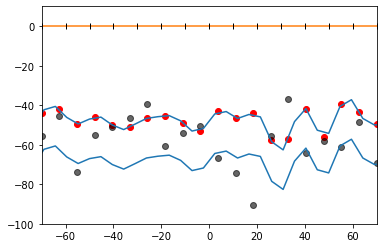

loss tf.Tensor(347.50982127054317, shape=(), dtype=float64)
grad tf.Tensor(
[2.30535885 2.74082563 2.96782095 3.72804511 4.04050904 4.26778632
 5.58221652 6.23844651 6.14611716 5.87564192 7.84053603 7.69977798
 7.86270757 5.41546652 4.99272654 7.46890582 4.25494305 6.41477881
 4.36763009 3.37980185], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.83737523 -42.21520227 -49.56525353 -46.02241065 -50.09367455
 -51.36588001 -46.74880187 -45.53969547 -49.02869962 -53.2875977
 -43.35439607 -46.58295502 -44.04549045 -57.55864511 -57.31961075
 -41.98565013 -56.36500644 -39.53601018 -43.4398322  -49.74408306], shape=(20,), dtype=float64)
Iteration 8


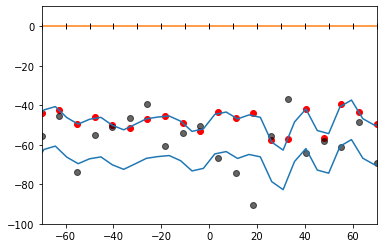

loss tf.Tensor(329.8794593273202, shape=(), dtype=float64)
grad tf.Tensor(
[2.29237433 2.71632007 2.9225021  3.66475584 3.96093553 4.1736484
 5.46219916 6.09897315 6.00254968 5.73100037 7.65954149 7.51916019
 7.68432136 5.28480718 4.87212439 7.3249439  4.16135182 6.31625338
 4.30762095 3.33728813], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.90614645 -42.29669187 -49.6529286  -46.13235332 -50.21250262
 -51.49108946 -46.91266784 -45.72266467 -49.20877611 -53.45952772
 -43.58418232 -46.80852982 -44.27602009 -57.71718933 -57.46577448
 -42.20539844 -56.489847   -39.72549778 -43.56906083 -49.8442017 ], shape=(20,), dtype=float64)
Iteration 9


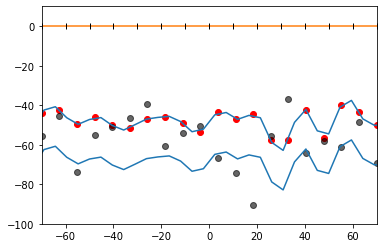

loss tf.Tensor(312.88442942152506, shape=(), dtype=float64)
grad tf.Tensor(
[2.27454736 2.6974883  2.87132462 3.60842988 3.87715918 4.08624355
 5.34109385 5.9657982  5.86107133 5.59075877 7.48438816 7.34211088
 7.51366202 5.15391326 4.75894215 7.17939998 4.07511401 6.21400022
 4.25317385 3.29154309], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-43.97438288 -42.37761652 -49.73906833 -46.24060622 -50.32881739
 -51.61367677 -47.07290066 -45.90163861 -49.38460825 -53.62725048
 -43.80871396 -47.02879315 -44.50142995 -57.87180673 -57.60854274
 -42.42078044 -56.61210042 -39.91191779 -43.69665605 -49.942948  ], shape=(20,), dtype=float64)
Iteration 10


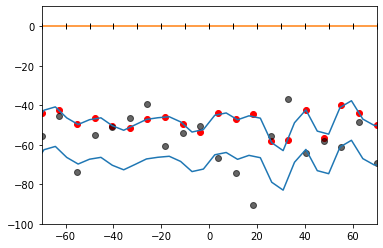

loss tf.Tensor(296.6623538054008, shape=(), dtype=float64)
grad tf.Tensor(
[2.26029851 2.67447394 2.82616451 3.54894631 3.80003265 3.99784875
 5.22671901 5.83488308 5.72557368 5.45487913 7.31491597 7.17257485
 7.34696287 5.03011561 4.64617599 7.04240976 3.98757694 6.11880367
 4.19652476 3.24966721], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.04219183 -42.45785074 -49.82385327 -46.34707461 -50.44281837
 -51.73361223 -47.22970223 -46.0766851  -49.55637546 -53.79089685
 -44.02816144 -47.2439704  -44.72183884 -58.0227102  -57.74792802
 -42.63205274 -56.73172772 -40.0954819  -43.82255179 -50.04043801], shape=(20,), dtype=float64)
Iteration 11


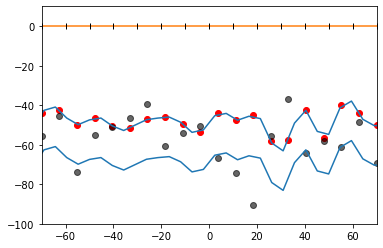

loss tf.Tensor(281.1320455156349, shape=(), dtype=float64)
grad tf.Tensor(
[2.24631456 2.65119353 2.78230917 3.49033355 3.72523712 3.91151432
 5.11593106 5.70775413 5.59444045 5.32328611 7.15105095 7.00885288
 7.18557403 4.91050986 4.53656385 6.90997572 3.90215906 6.02647577
 4.14080992 3.20890644], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.10958127 -42.53738655 -49.90732255 -46.45178461 -50.55457548
 -51.85095766 -47.38318016 -46.24791773 -49.72420867 -53.95059544
 -44.24269297 -47.45423598 -44.93740606 -58.17002549 -57.88402494
 -42.83935201 -56.8487925  -40.27627617 -43.94677609 -50.13670521], shape=(20,), dtype=float64)
Iteration 12


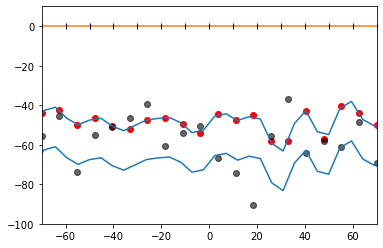

loss tf.Tensor(266.1682684991828, shape=(), dtype=float64)
grad tf.Tensor(
[2.22867315 2.63222328 2.73419277 3.43716009 3.64762925 3.83056199
 5.00490565 5.58584688 5.46560996 5.19548783 6.99250354 6.84843603
 7.03092885 4.79114412 4.43325206 6.776806   3.82287323 5.93158222
 4.08970556 3.16573544], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.17644146 -42.61635325 -49.98934833 -46.55489941 -50.66400436
 -51.96587452 -47.53332733 -46.41549314 -49.88817697 -54.10646007
 -44.45246808 -47.65968906 -45.14833393 -58.31375982 -58.0170225
 -43.04265619 -56.96347869 -40.45422364 -44.06946725 -50.23167727], shape=(20,), dtype=float64)
Iteration 13


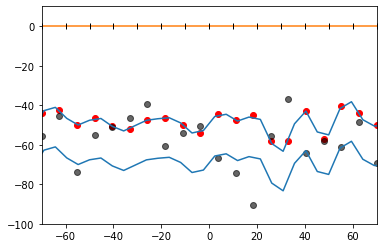

loss tf.Tensor(251.88635826024372, shape=(), dtype=float64)
grad tf.Tensor(
[2.21806746 2.60523137 2.69678087 3.37669472 3.58064025 3.74527207
 4.90296294 5.46406422 5.34322305 5.0714597  6.83808857 6.69622147
 6.87726857 4.68120152 4.32643556 6.65557476 3.73791307 5.84775739
 4.03258926 3.12931236], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.24298349 -42.69451019 -50.07025175 -46.65620026 -50.77142357
 -52.07823268 -47.68041622 -46.57941506 -50.04847366 -54.25860386
 -44.65761073 -47.86057571 -45.35465198 -58.45419586 -58.14681557
 -43.24232343 -57.07561609 -40.62965636 -44.19044493 -50.32555664], shape=(20,), dtype=float64)
Iteration 14


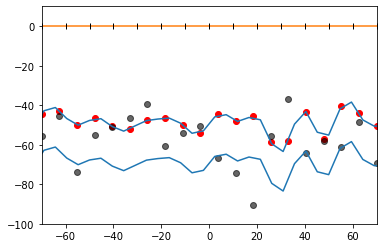

loss tf.Tensor(238.11365276220684, shape=(), dtype=float64)
grad tf.Tensor(
[2.20115841 2.58563761 2.65135526 3.32488223 3.50746257 3.6678021
 4.79841438 5.34871355 5.22204462 4.95115103 6.68916551 6.5459592
 6.73166742 4.56924616 4.228372   6.53051606 3.66206508 5.75811279
 3.98285628 3.08828155], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.30901824 -42.77207932 -50.14979241 -46.75594672 -50.87664745
 -52.18826674 -47.82436865 -46.73987647 -50.205135   -54.40713839
 -44.8582857  -48.05695448 -45.556602   -58.59127325 -58.27366673
 -43.43823891 -57.18547804 -40.80239975 -44.30993062 -50.41820509], shape=(20,), dtype=float64)
Iteration 15


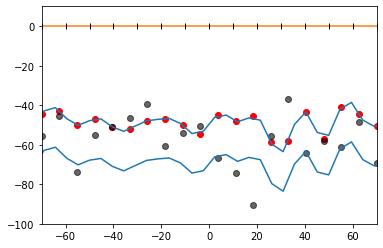

loss tf.Tensor(224.90994914612864, shape=(), dtype=float64)
grad tf.Tensor(
[2.18922352 2.56045674 2.61365546 3.26813026 3.44208917 3.58760496
 4.70074531 5.23398972 5.10597227 4.83406456 6.54387679 6.40218985
 6.58746961 4.46435699 4.12826565 6.41430618 3.58252782 5.67647844
 3.9289923  3.05206312], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.37469494 -42.84889302 -50.22820208 -46.85399063 -50.97991012
 -52.29589489 -47.96539101 -46.89689616 -50.35831417 -54.55216033
 -45.054602   -48.24902018 -45.75422609 -58.72520396 -58.3975147
 -43.6306681  -57.29295387 -40.9726941  -44.42780039 -50.50976698], shape=(20,), dtype=float64)
Iteration 16


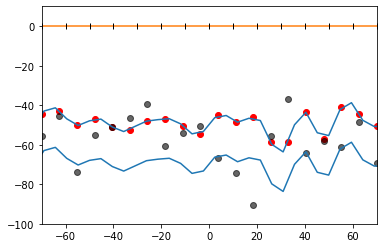

loss tf.Tensor(212.2083815595253, shape=(), dtype=float64)
grad tf.Tensor(
[2.17348435 2.53982358 2.57140032 3.21706333 3.3735933  3.5129157
 4.60252685 5.12438034 4.99191925 4.72053617 6.40357913 6.26128303
 6.44977756 4.35947667 4.03453384 6.29710713 3.50930461 5.59217529
 3.88005742 3.01337583], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.43989947 -42.92508772 -50.30534409 -46.95050253 -51.08111792
 -52.40128236 -48.10346681 -47.05062757 -50.50807174 -54.69377641
 -45.24670938 -48.43685867 -45.94771942 -58.85598826 -58.51855071
 -43.81958131 -57.39823301 -41.14045936 -44.54420211 -50.60016826], shape=(20,), dtype=float64)
Iteration 17


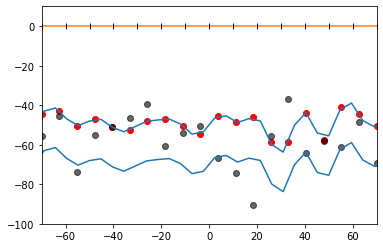

loss tf.Tensor(200.06080546253858, shape=(), dtype=float64)
grad tf.Tensor(
[2.16240249 2.51398648 2.53641389 3.16149071 3.31254087 3.43583534
 4.51099788 5.01556413 4.88296501 4.61024026 6.26706455 6.12674376
 6.31375373 4.26153142 3.93920835 6.18854817 3.43289257 5.51565119
 3.82750624 2.97931425], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.50477155 -43.00050732 -50.3814365  -47.04534725 -51.18049415
 -52.50435742 -48.23879675 -47.20109449 -50.65456069 -54.83208362
 -45.43472131 -48.62066098 -46.13713203 -58.9838342  -58.63672696
 -44.00523776 -57.50121979 -41.30592889 -44.6590273  -50.68954768], shape=(20,), dtype=float64)
Iteration 18


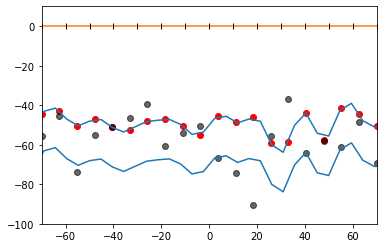

loss tf.Tensor(188.27759658988904, shape=(), dtype=float64)
grad tf.Tensor(
[2.14470712 2.49599106 2.49280525 3.11479968 3.24446315 3.36648754
 4.41580628 4.91261407 4.77408251 4.50282885 6.13474906 5.99279746
 6.18472973 4.1603537  3.85212534 6.07476951 3.36538053 5.43228349
 3.78230346 2.94014696], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.56911276 -43.07538705 -50.45622066 -47.13879124 -51.27782804
 -52.60535205 -48.37127094 -47.34847292 -50.79778317 -54.96716849
 -45.61876379 -48.80044491 -46.32267392 -59.10864481 -58.75229072
 -44.18748084 -57.6021812  -41.4688974  -44.7724964  -50.77775209], shape=(20,), dtype=float64)
Iteration 19


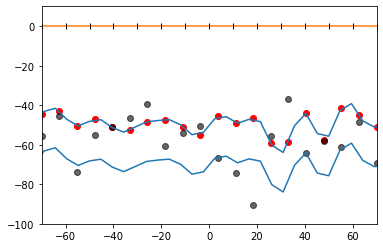

loss tf.Tensor(177.01951637685156, shape=(), dtype=float64)
grad tf.Tensor(
[2.1317081  2.47278589 2.45648531 3.06358094 3.18382643 3.29469685
 4.32725666 4.81035176 4.67020758 4.39854343 6.00605209 5.86507975
 6.05719315 4.06609616 3.76335345 5.96963148 3.29461122 5.35676141
 3.73348431 2.90566424], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.63306401 -43.14957063 -50.52991522 -47.23069867 -51.37334283
 -52.70419296 -48.50108864 -47.49278347 -50.9378894  -55.09912479
 -45.79894535 -48.9763973  -46.50438972 -59.23062769 -58.86519132
 -44.36656979 -57.70101954 -41.62960024 -44.88450093 -50.86492202], shape=(20,), dtype=float64)
Iteration 20


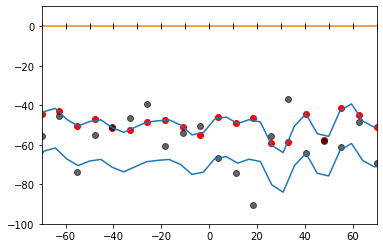

loss tf.Tensor(166.1810062773301, shape=(), dtype=float64)
grad tf.Tensor(
[2.11808708 2.45051709 2.41993993 3.01410651 3.123764   3.22516458
 4.24039382 4.71105542 4.56887862 4.29709009 5.88105234 5.74069442
 5.93355378 3.97381397 3.67747426 5.86643329 3.22625426 5.28206628
 3.68620475 2.87121742], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.69660662 -43.22308614 -50.60251342 -47.32112187 -51.46705575
 -52.80094789 -48.62830045 -47.63411513 -51.07495576 -55.22803749
 -45.97537692 -49.14861813 -46.68239633 -59.34984211 -58.97551555
 -44.54256279 -57.79780717 -41.78806223 -44.99508707 -50.95105854], shape=(20,), dtype=float64)
Iteration 21


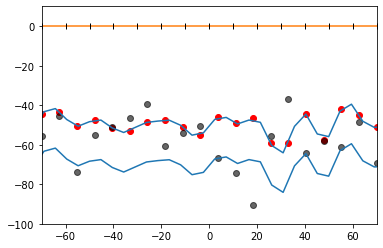

loss tf.Tensor(155.74139192882487, shape=(), dtype=float64)
grad tf.Tensor(
[2.1040081  2.42900866 2.38336916 2.96615956 3.06441488 3.1576833
 4.15524642 4.61453462 4.47001263 4.19833992 5.75953936 5.61953671
 5.81354064 3.88351798 3.59422231 5.76522947 3.16004781 5.20832439
 3.64025828 2.83691843], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.75972686 -43.2959564  -50.67401449 -47.41010665 -51.5589882
 -52.89567839 -48.75295784 -47.77255117 -51.20905613 -55.35398769
 -46.1481631  -49.31720423 -46.85680255 -59.46634765 -59.08334222
 -44.71551967 -57.8926086  -41.94431196 -45.10429482 -51.0361661 ], shape=(20,), dtype=float64)
Iteration 22


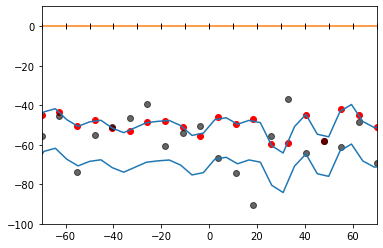

loss tf.Tensor(145.6765424319045, shape=(), dtype=float64)
grad tf.Tensor(
[2.08869443 2.40916554 2.34566279 2.92066099 3.00475332 3.09293417
 4.07105534 4.52109359 4.3732076  4.10221422 5.64146616 5.50112768
 5.6974532  3.79446326 3.51424827 5.66502329 3.09681406 5.13451864
 3.59641378 2.8020967 ], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.82238769 -43.36823137 -50.74438438 -47.49772648 -51.6491308
 -52.98846642 -48.8750895  -47.90818398 -51.34025236 -55.47705412
 -46.31740708 -49.48223806 -47.02772615 -59.58018155 -59.18876967
 -44.88547037 -57.98551302 -42.09834752 -45.21218724 -51.120229  ], shape=(20,), dtype=float64)
Iteration 23


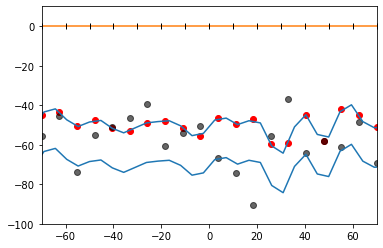

loss tf.Tensor(135.9678825944881, shape=(), dtype=float64)
grad tf.Tensor(
[2.07193599 2.391216   2.30651705 2.87781213 2.94449462 3.03102529
 3.98759636 4.43070386 4.27832944 4.00857054 5.52677742 5.38519044
 5.58533677 3.70633159 3.43773267 5.56542375 3.03679714 5.06028298
 3.5549169  2.76651839], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.88454577 -43.43996785 -50.81357989 -47.58406085 -51.73746564
 -53.07939718 -48.9947174  -48.04110509 -51.46860225 -55.59731123
 -46.48321041 -49.64379378 -47.19528625 -59.6913715  -59.29190165
 -45.05243308 -58.07661694 -42.25015601 -45.31883474 -51.20322455], shape=(20,), dtype=float64)
Iteration 24


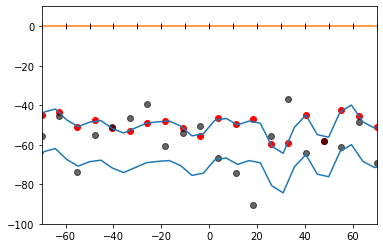

loss tf.Tensor(126.67578209555143, shape=(), dtype=float64)
grad tf.Tensor(
[2.05963263 2.36844478 2.27418098 2.83069535 2.8910723  2.96670442
 3.91006124 4.34069217 4.18770791 3.91756078 5.41486176 5.27466011
 5.4739873  3.62444359 3.35920023 5.47365626 2.97338801 4.993302
 3.50981751 2.73535726], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-44.94633475 -43.51102119 -50.88180532 -47.66898171 -51.82419781
 -53.16839831 -49.11201923 -48.17132586 -51.59423348 -55.71483806
 -46.64565626 -49.80203358 -47.35950587 -59.80010481 -59.39267766
 -45.21664277 -58.16581858 -42.39995507 -45.42412927 -51.28528527], shape=(20,), dtype=float64)
Iteration 25


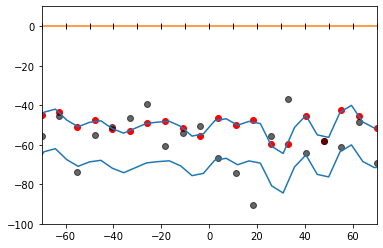

loss tf.Tensor(117.6748911633579, shape=(), dtype=float64)
grad tf.Tensor(
[2.04352637 2.3502694  2.23705161 2.78895658 2.83396153 2.90722465
 3.83098482 4.25460718 4.09783263 3.82875118 5.3062484  5.16511771
 5.36757954 3.54113574 3.28612638 5.37937352 2.91570717 4.92268706
 3.46938123 2.7013311 ], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.00764054 -43.58152927 -50.94891686 -47.7526504  -51.90921665
 -53.25561505 -49.22694878 -48.29896407 -51.71716846 -55.82970059
 -46.80484371 -49.95698711 -47.52053326 -59.90633888 -59.49126145
 -45.37802397 -58.25328979 -42.54763568 -45.5282107  -51.3663252 ], shape=(20,), dtype=float64)
Iteration 26


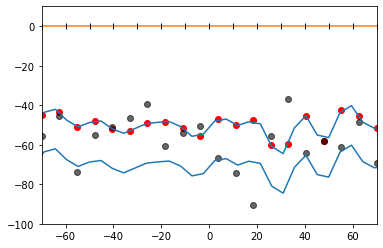

loss tf.Tensor(109.05009109999409, shape=(), dtype=float64)
grad tf.Tensor(
[2.03112292 2.32815954 2.20563683 2.74382263 2.78265345 2.84594434
 3.75702827 4.16911075 4.01173447 3.74240692 5.20024145 5.06039713
 5.26210648 3.46326319 3.21158596 5.29185697 2.85537161 4.85827264
 3.42605243 2.67104877], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.06857423 -43.65137406 -51.01508597 -47.83496508 -51.99269626
 -53.34099338 -49.33965963 -48.4240374  -51.8375205  -55.9419728
 -46.96085096 -50.10879902 -47.67839645 -60.01023677 -59.58760903
 -45.53677968 -58.33895094 -42.69338386 -45.63099228 -51.44645666], shape=(20,), dtype=float64)
Iteration 27


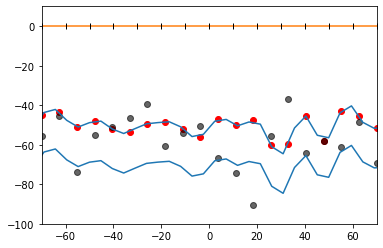

loss tf.Tensor(100.73089518301077, shape=(), dtype=float64)
grad tf.Tensor(
[2.01870156 2.30633319 2.1746962  2.6995712  2.73237335 2.78602976
 3.68476816 4.08566196 3.92775594 3.65818191 5.09697999 4.9583231
 5.15935891 3.38721121 3.13889817 5.20627035 2.79646466 4.795016
 3.38354467 2.64115647], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.12913528 -43.72056405 -51.08032686 -47.91595222 -52.07466746
 -53.42457427 -49.45020267 -48.54660726 -51.95535317 -56.05171826
 -47.11376036 -50.25754872 -47.83317722 -60.11185311 -59.68177597
 -45.69296779 -58.42284488 -42.83723434 -45.73249862 -51.52569136], shape=(20,), dtype=float64)
Iteration 28


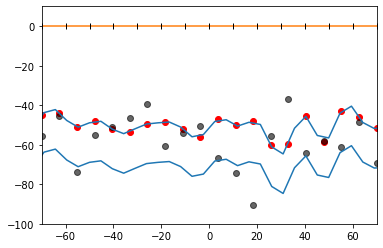

loss tf.Tensor(92.69684822684272, shape=(), dtype=float64)
grad tf.Tensor(
[2.00467866 2.28662433 2.14199868 2.65812236 2.68109885 2.72896733
 3.61277744 4.00505042 3.84523587 3.57610463 4.99658368 4.85816668
 5.06015701 3.31163898 3.06951257 5.12077481 2.7407433  4.73097149
 3.34345829 2.6103427 ], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.18927564 -43.78916278 -51.14458682 -47.99569589 -52.15510042
 -53.50644329 -49.55858599 -48.66675877 -52.07071025 -56.1590014
 -47.26365787 -50.40329372 -47.98498193 -60.21120228 -59.77386135
 -45.84659104 -58.50506718 -42.97916349 -45.83280237 -51.60400164], shape=(20,), dtype=float64)
Iteration 29


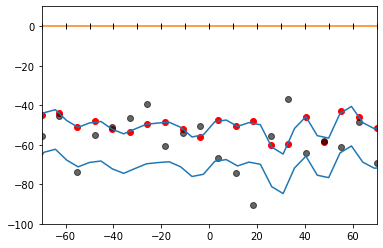

loss tf.Tensor(84.93220875003956, shape=(), dtype=float64)
grad tf.Tensor(
[1.98906841 2.26901454 2.10754257 2.6194244  2.628796   2.67467938
 3.54098012 3.92716275 3.76406898 3.49605594 4.8989089  4.75977615
 4.96436133 3.23643343 3.00333418 5.0352551  2.68813659 4.66607056
 3.30575052 2.57858132], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.24894769 -43.85723322 -51.20781309 -48.07427862 -52.2339643
 -53.58668367 -49.6648154  -48.78457365 -52.18363232 -56.26388307
 -47.41062513 -50.546087   -48.13391277 -60.30829528 -59.86396137
 -45.99764869 -58.58571128 -43.1191456  -45.93197488 -51.68135908], shape=(20,), dtype=float64)
Iteration 30


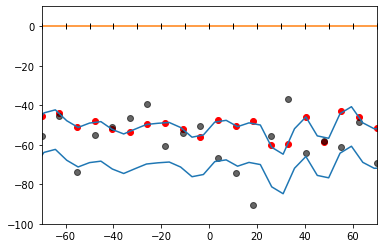

loss tf.Tensor(77.4623575253434, shape=(), dtype=float64)
grad tf.Tensor(
[1.97539951 2.24948273 2.07626227 2.57929163 2.57991515 2.61994289
 3.4724781  3.85029445 3.68563421 3.41801994 4.8035579  4.66479495
 4.87001114 3.16468352 2.93706313 4.95392199 2.63467754 4.60480308
 3.26685828 2.54890752], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.30820968 -43.9247177  -51.27010096 -48.15165737 -52.31136176
 -53.66528196 -49.76898974 -48.90008248 -52.29420135 -56.36642367
 -47.55473187 -50.68603085 -48.2800131  -60.40323579 -59.95207327
 -46.14626635 -58.6647516  -43.25728969 -46.02998063 -51.7578263 ], shape=(20,), dtype=float64)
Iteration 31


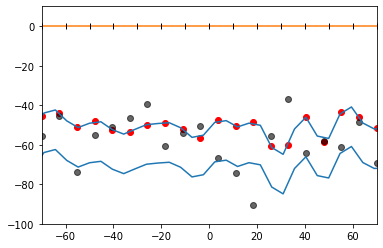

loss tf.Tensor(70.2457673314974, shape=(), dtype=float64)
grad tf.Tensor(
[1.96115689 2.23089323 2.04460891 2.54066194 2.53121528 2.56696815
 3.4049452  3.77551673 3.60880402 3.34184923 4.71062621 4.57184315
 4.77832479 3.09403021 2.87294105 4.87360434 2.58311789 4.54385711
 3.22928352 2.51911157], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.36704438 -43.9916445  -51.33143923 -48.22787723 -52.38729822
 -53.742291   -49.8711381  -49.01334799 -52.40246547 -56.46667915
 -47.69605066 -50.82318615 -48.42336285 -60.49605669 -60.0382615
 -46.29247448 -58.74224514 -43.39360541 -46.12685914 -51.83339965], shape=(20,), dtype=float64)
Iteration 32


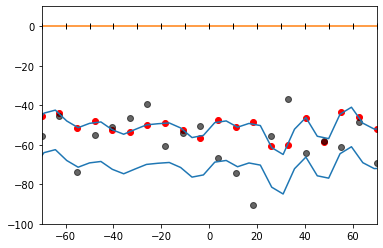

loss tf.Tensor(63.294942085594045, shape=(), dtype=float64)
grad tf.Tensor(
[1.94775095 2.21165567 2.01455892 2.50190392 2.48449411 2.5145237
 3.339657   3.70221844 3.53417519 3.26761303 4.62000825 4.48166764
 4.68856556 3.02580489 2.80968671 4.79608952 2.53189927 4.48511821
 3.19162951 2.49045936], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.42547691 -44.05799417 -51.391876   -48.30293435 -52.46183304
 -53.81772671 -49.97132781 -49.12441454 -52.50849072 -56.56470754
 -47.8346509  -50.95763617 -48.56401981 -60.58683084 -60.1225521
 -46.43635717 -58.81820212 -43.52815895 -46.22260802 -51.90811343], shape=(20,), dtype=float64)
Iteration 33


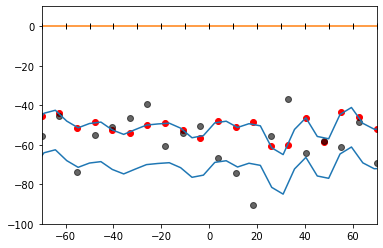

loss tf.Tensor(56.58780589500131, shape=(), dtype=float64)
grad tf.Tensor(
[1.93376254 2.19338342 1.9841173  2.46468176 2.43794226 2.46386949
 3.27533293 3.6310217  3.46115309 3.195247   4.53180687 4.39351349
 4.60147049 2.95870274 2.74861166 4.71961983 2.48261552 4.42674577
 3.15534603 2.46171753], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.48348979 -44.12379567 -51.45139952 -48.3768748  -52.53497131
 -53.8916428  -50.06958779 -49.23334519 -52.61232531 -56.66056495
 -47.97060511 -51.08944158 -48.70206393 -60.67559192 -60.20501045
 -46.57794576 -58.89268058 -43.66096133 -46.3172684  -51.98196496], shape=(20,), dtype=float64)
Iteration 34


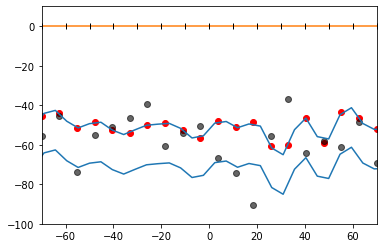

loss tf.Tensor(50.142280505102974, shape=(), dtype=float64)
grad tf.Tensor(
[1.92277985 2.1720026  1.95828785 2.42472713 2.39605423 2.41169497
 3.21507289 3.56014411 3.39106375 3.12468517 4.44551909 4.3089935
 4.51493776 2.89581452 2.68626521 4.64841063 2.43115061 4.37324436
 3.11674087 2.43594558], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.54117318 -44.18895575 -51.51014815 -48.44961661 -52.60685293
 -53.96399365 -50.16603998 -49.34014951 -52.71405723 -56.7543055
 -48.10397068 -51.21871138 -48.83751206 -60.76246636 -60.28559841
 -46.71739808 -58.9656151  -43.79215866 -46.41077063 -52.05504332], shape=(20,), dtype=float64)
Iteration 35


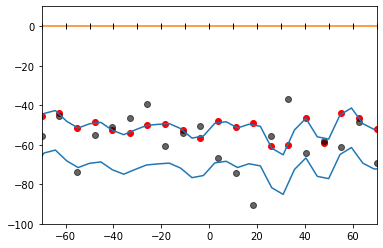

loss tf.Tensor(43.850626097925385, shape=(), dtype=float64)
grad tf.Tensor(
[1.90648664 2.15692994 1.9253557  2.39173858 2.34813227 2.3653393
 3.15122435 3.49320617 3.32024766 3.0555207  4.3615824  4.22364476
 4.43314624 2.82936426 2.63015051 4.57202715 2.38667096 4.31369543
 3.08410829 2.40583363], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.59836778 -44.25366365 -51.56790882 -48.52136877 -52.6772969
 -54.03495383 -50.26057671 -49.4449457  -52.81366466 -56.84597113
 -48.23481815 -51.34542073 -48.97050645 -60.84734729 -60.36450292
 -46.85455889 -59.03721523 -43.92156952 -46.50329388 -52.12721833], shape=(20,), dtype=float64)
Iteration 36


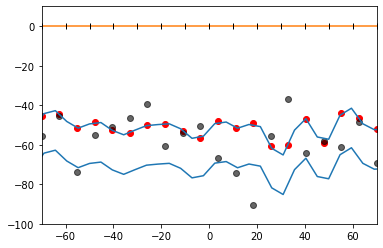

loss tf.Tensor(37.832805051448446, shape=(), dtype=float64)
grad tf.Tensor(
[1.89462291 2.13716596 1.89903931 2.35440819 2.30671666 2.31626507
 3.09277249 3.42602381 3.25301939 2.98828929 4.27950845 4.14275733
 4.35121856 2.76855585 2.57151036 4.50279587 2.33846785 4.2609936
 3.04777706 2.38001152], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.65520647 -44.31777863 -51.62488    -48.59200102 -52.7464984
 -54.10444178 -50.35335989 -49.54772641 -52.91125524 -56.9356198
 -48.36320341 -51.46970345 -49.101043   -60.93040396 -60.44164823
 -46.98964277 -59.10736927 -44.04939933 -46.59472719 -52.19861868], shape=(20,), dtype=float64)
Iteration 37


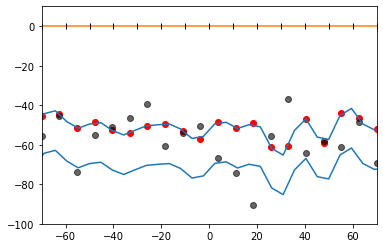

loss tf.Tensor(32.007127842564444, shape=(), dtype=float64)
grad tf.Tensor(
[1.88185679 2.11871731 1.87180989 2.31887478 2.26490148 2.26906327
 3.03472874 3.36076529 3.18692984 2.92256604 4.19945007 4.06327095
 4.2717163  2.70822101 2.51507682 4.43382969 2.29236489 4.2079807
 3.01302711 2.35370783], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.71166217 -44.38134015 -51.6810343  -48.66156726 -52.81444545
 -54.17251368 -50.44440175 -49.64854937 -53.00686313 -57.02329679
 -48.48918691 -51.59160158 -49.22919449 -61.01165059 -60.51710054
 -47.12265766 -59.17614021 -44.17563875 -46.685118   -52.26922991], shape=(20,), dtype=float64)
Iteration 38


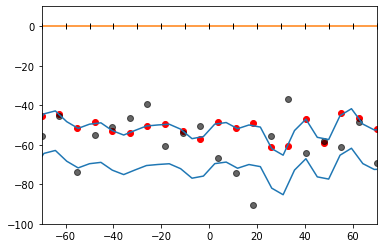

loss tf.Tensor(26.351117987018966, shape=(), dtype=float64)
grad tf.Tensor(
[1.86672255 2.10324026 1.84159427 2.28684331 2.22078227 2.22502032
 2.9757161  3.298051   3.12130342 2.85825719 4.12144888 3.98436461
 4.19534779 2.64696579 2.4621595  4.36326998 2.2499709  4.15273033
 2.98132165 2.32563712], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.76766385 -44.44443735 -51.73628213 -48.73017256 -52.88106892
 -54.23926429 -50.53367323 -49.7474909  -53.10050224 -57.1090445
 -48.61283038 -51.71113251 -49.35505493 -61.09105957 -60.59096532
 -47.25355576 -59.24363934 -44.30022066 -46.77455765 -52.33899903], shape=(20,), dtype=float64)
Iteration 39


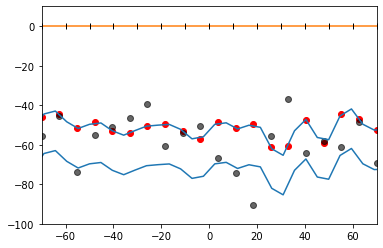

loss tf.Tensor(20.924530648343335, shape=(), dtype=float64)
grad tf.Tensor(
[1.85532168 2.08386503 1.81695868 2.25120876 2.18215334 2.17873198
 2.92125839 3.23517029 3.05870195 2.79560455 4.04501805 3.90923472
 4.11886829 2.59046207 2.40711696 4.29872332 2.20444797 4.10322706
 2.94650098 2.30116616], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.8233235  -44.5069533  -51.79079089 -48.79770882 -52.94653352
 -54.30462625 -50.62131098 -49.84454601 -53.1922633  -57.19291264
 -48.73418092 -51.82840956 -49.47862098 -61.16877343 -60.66317883
 -47.38251746 -59.30977278 -44.42331747 -46.86295268 -52.40803401], shape=(20,), dtype=float64)
Iteration 40


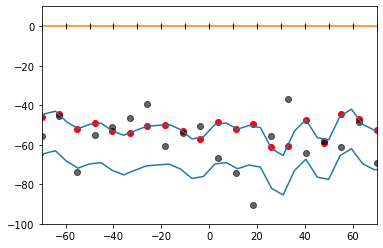

loss tf.Tensor(15.643962320997616, shape=(), dtype=float64)
grad tf.Tensor(
[1.84043593 2.06871126 1.78775487 2.22035272 2.13976733 2.13655096
 2.86477848 3.17526159 2.99604501 2.73424719 3.97066622 3.83400133
 4.04605476 2.53193447 2.35659862 4.2311236  2.16387539 4.04998954
 2.91586213 2.27393542], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.87853658 -44.56901464 -51.84442353 -48.8643194  -53.01072654
 -54.36872278 -50.70725434 -49.93980386 -53.28214465 -57.27494005
 -48.8533009  -51.9434296  -49.60000262 -61.24473146 -60.73387679
 -47.50945117 -59.37468904 -44.54481716 -46.95042854 -52.47625207], shape=(20,), dtype=float64)
Iteration 41


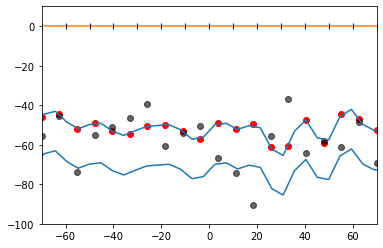

loss tf.Tensor(10.548985508992061, shape=(), dtype=float64)
grad tf.Tensor(
[1.82704621 2.05216943 1.76095581 2.18843937 2.09993865 2.09400304
 2.81070409 3.11602128 2.93531908 2.67428551 3.89786631 3.7611549
 3.97413018 2.47590936 2.30589884 4.16656607 2.12259133 3.99944593
 2.88431629 2.24828019], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.93334796 -44.63057972 -51.89725221 -48.92997258 -53.07372469
 -54.43154287 -50.79157546 -50.0332845  -53.37020422 -57.35516862
 -48.97023689 -52.05626424 -49.71922652 -61.31900874 -60.80305376
 -47.63444815 -59.43836678 -44.66480054 -47.03695803 -52.54370048], shape=(20,), dtype=float64)
Iteration 42


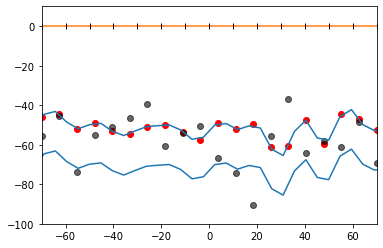

loss tf.Tensor(5.650991419010921, shape=(), dtype=float64)
grad tf.Tensor(
[1.81561882 2.033752   1.73723283 2.15501772 2.06331356 2.05080496
 2.75954598 3.05740945 2.87683037 2.61591774 3.82671196 3.69115125
 3.90296496 2.42302774 2.2546729  4.10585091 2.08013398 3.95238932
 2.85144155 2.22471808], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-45.98781653 -44.69159228 -51.94936919 -48.99462312 -53.1356241
 -54.49306702 -50.87436184 -50.12500678 -53.45650913 -57.43364615
 -49.08503825 -52.16699878 -49.83631547 -61.39169958 -60.87069394
 -47.75762368 -59.5007708  -44.78337222 -47.12250128 -52.61044202], shape=(20,), dtype=float64)
Iteration 43


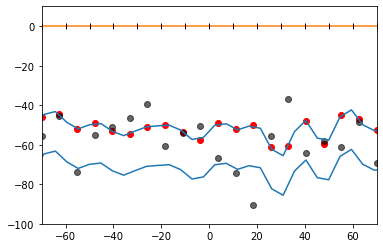

loss tf.Tensor(0.8750154911692221, shape=(), dtype=float64)
grad tf.Tensor(
[1.80154597 2.01856758 1.71006357 2.12525748 2.02387168 2.01075474
 2.70690674 3.00108705 2.81836841 2.55854527 3.75723408 3.62107175
 3.83470252 2.36855476 2.20698148 4.04275956 2.04153249 3.90242468
 2.82180464 2.19899841], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.04186291 -44.75214931 -52.0006711  -49.05838084 -53.19634025
 -54.55338966 -50.95556904 -50.21503939 -53.54106018 -57.51040251
 -49.19775527 -52.27563093 -49.95135655 -61.46275622 -60.93690339
 -47.87890646 -59.56201678 -44.90044496 -47.20715542 -52.67641197], shape=(20,), dtype=float64)
Iteration 44


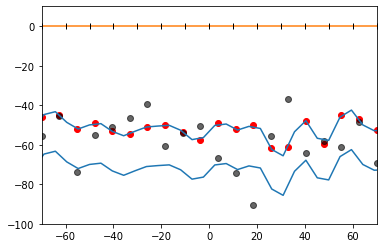

loss tf.Tensor(-3.706926568367095, shape=(), dtype=float64)
grad tf.Tensor(
[1.78956208 2.00138463 1.68615279 2.09387662 1.987814   1.96998491
 2.65732975 2.94538267 2.76223527 2.50282071 3.68942992 3.5539547
 3.7671653  2.317413   2.15868378 3.98374229 2.00164776 3.85618366
 2.79074785 2.17552989], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.09554977 -44.81219085 -52.05125568 -49.12119714 -53.25597467
 -54.6124892  -51.03528893 -50.30340087 -53.62392724 -57.58548713
 -49.30843817 -52.38224957 -50.06437151 -61.53227861 -61.0016639
 -47.99841873 -59.62206621 -45.01613047 -47.29087785 -52.74167787], shape=(20,), dtype=float64)
Iteration 45


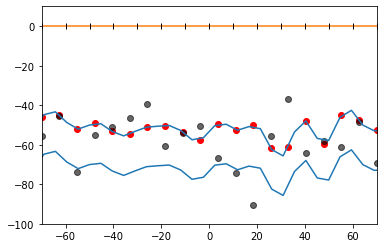

loss tf.Tensor(-8.170749965022878, shape=(), dtype=float64)
grad tf.Tensor(
[1.77609323 1.98612018 1.66039532 2.06475957 1.95035682 1.93125691
 2.6072165  2.89133384 2.70648464 2.448011   3.6230456  3.48721126
 3.70175378 2.26563408 2.11273368 3.92366155 1.96423078 3.80846006
 2.76170058 2.15088303], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.14883257 -44.87177446 -52.10106754 -49.18313993 -53.31448538
 -54.67042691 -51.11350543 -50.39014089 -53.70512178 -57.65892746
 -49.41712954 -52.48686591 -50.17542412 -61.60024763 -61.06504591
 -48.11612858 -59.68099313 -45.13038427 -47.37372887 -52.80620436], shape=(20,), dtype=float64)
Iteration 46


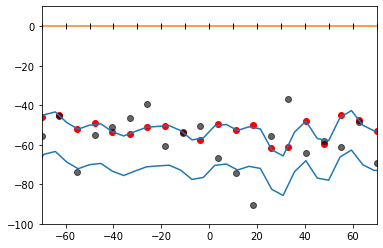

loss tf.Tensor(-12.452663212925728, shape=(), dtype=float64)
grad tf.Tensor(
[1.76479296 1.96877683 1.63798863 2.03391927 1.91634634 1.8917107
 2.56017379 2.83781468 2.65301512 2.39479588 3.55822287 3.42339552
 3.63691827 2.21721238 2.06602845 3.86769837 1.92538253 3.76453273
 2.73111735 2.12855175], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.20177636 -44.93083776 -52.1502072  -49.2441575  -53.37197577
 -54.72717823 -51.19031064 -50.47527533 -53.78471223 -57.73077134
 -49.52387623 -52.58956778 -50.28453167 -61.666764   -61.12702676
 -48.23215953 -59.73875461 -45.24332025 -47.45566239 -52.87006091], shape=(20,), dtype=float64)
Iteration 47


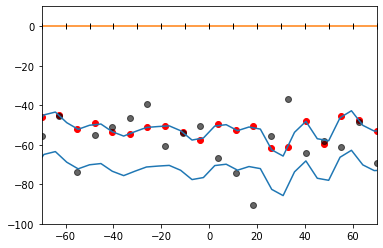

loss tf.Tensor(-16.63901464993573, shape=(), dtype=float64)
grad tf.Tensor(
[1.75100148 1.95445403 1.61230097 2.00644854 1.87960212 1.85500385
 2.51160532 2.78626585 2.59941365 2.34231298 3.49478739 3.35925026
 3.57464279 2.16707238 2.02254527 3.80926821 1.89009574 3.71770244
 2.70354763 2.10410542], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.2543064  -44.98947138 -52.19857623 -49.30435096 -53.42836383
 -54.78282835 -51.2656588  -50.5588633  -53.86269464 -57.80104073
 -49.62871985 -52.69034528 -50.39177095 -61.73177617 -61.18770312
 -48.34643758 -59.79545748 -45.35485132 -47.53676882 -52.93318408], shape=(20,), dtype=float64)
Iteration 48


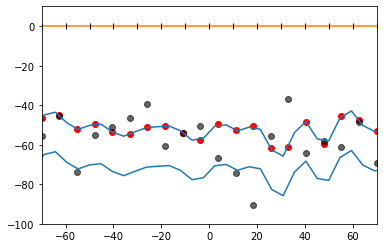

loss tf.Tensor(-20.658709408153314, shape=(), dtype=float64)
grad tf.Tensor(
[1.73872323 1.93878627 1.58903673 1.97800257 1.84545348 1.8180336
 2.46549073 2.73549467 2.54779078 2.29135191 3.4329272  3.29762755
 3.51325675 2.11963998 1.97890134 3.75409712 1.8541094  3.67379015
 2.67511312 2.08139392], shape=(20,), dtype=float64)
mu: tf.Tensor(
[-46.3064681  -45.04763497 -52.24624733 -49.36369104 -53.48372743
 -54.83736936 -51.33962352 -50.64092814 -53.93912836 -57.86978128
 -49.73170766 -52.78927411 -50.49716865 -61.79536537 -61.24707016
 -48.45906049 -59.85108076 -45.46506503 -47.61702221 -52.99562589], shape=(20,), dtype=float64)
Iteration 49


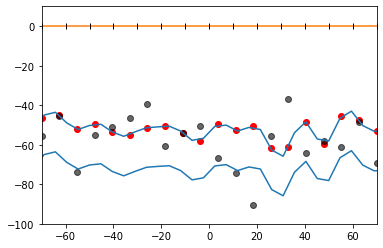

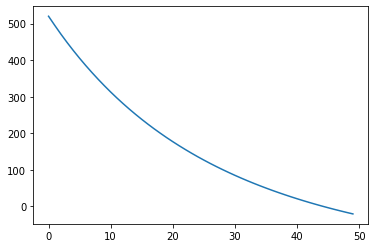

In [225]:
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(D,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('loss',loss)
        print('grad',dlossdmu)
    mu = mu-tf.multiply(constant64(0.03),dlossdmu)
    print('mu:',mu)
    f,ax = plt.subplots()
    Draw_inter(control_index,mu,ax = ax)
    print('Iteration',i)
    plt.show()
plt.plot(lost)

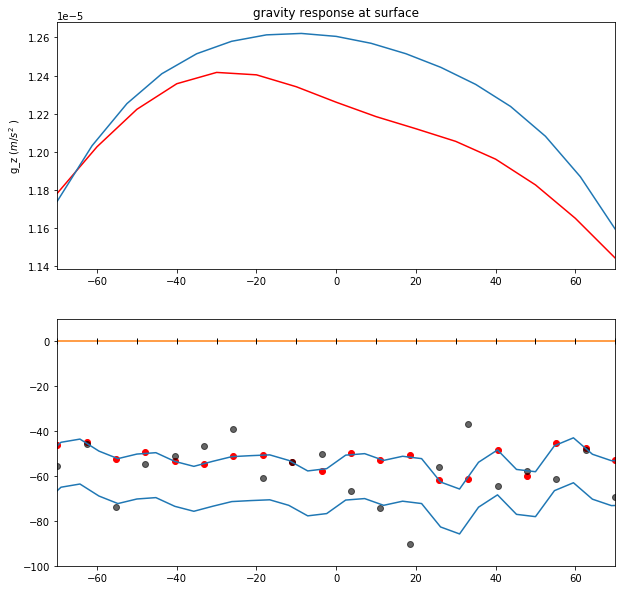

In [241]:
f,ax = plt.subplots(2,figsize =(10,10))
ax[0].plot(x_obs,D,'r')
Draw(control_index,mu,ax)

In [242]:
MAP = mu

In [251]:
negative_log_posterior(D,mu)

<tf.Tensor: shape=(), dtype=float64, numpy=-55.05148478679844>

### Random Walk MCMC

In [267]:
joint_log_post(D,initial_chain_state[0])

<tf.Tensor: shape=(), dtype=float64, numpy=-84.44909316997465>

In [304]:
# num_results = number_sample
# burnin = number_burnin

num_results=2
burnin = 0

initial_chain_state = [
    -50 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [305]:
samples

array([[[-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.]],

       [[-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.],
        [-50.]]])

In [274]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [303]:
print('Acceptance rate = %0.1f%%' % (100*accepted_samples.shape[0]/num_results))

Acceptance rate = 100.0%


In [283]:
#TODO
def draw_MCMC(samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots(figsize = (10,5))
    
#     if Truth is not None:
#         draw(base,Truth,ax = ax, R = R)
            
    x_cor = tf.linspace(constant64(-70),constant64(70),Number_para)
    
    for ps in samples:
        ax.plot(x_cor,ps,'r.',alpha =0.2)
        ps = tf.reshape(ps,[ps.shape[0]])
        GaussianProcess_model_plot(control_index,ps,ax = ax, alpha = 0.2)
    ax.set_ylim(-70,0)
    ax.set_xlim(-R,R)

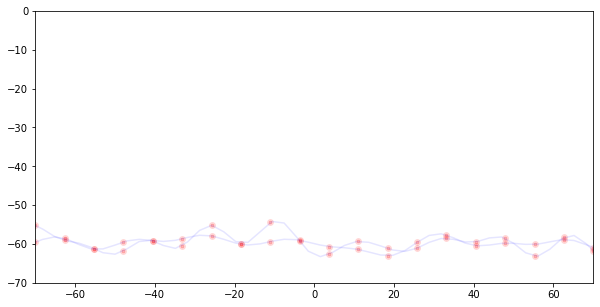

In [284]:
draw_MCMC(samples) # [:,:,0] transpost the results for plotting

In [ ]:
corner.corner(accepted_samples[:,:,0])

# Hessian Method

### Could be parelized?

In [285]:
with tf.GradientTape() as t:
    t.watch(MAP)
    with tf.GradientTape() as tt:
        tt.watch(MAP)
        loss = negative_log_posterior(D,MAP)
    jac = tt.gradient(loss,MAP,unconnected_gradients='zero')
hess = t.gradient(jac,MAP,unconnected_gradients = 'none')

In [286]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        print(j)
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(D,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = Full_Hessian()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


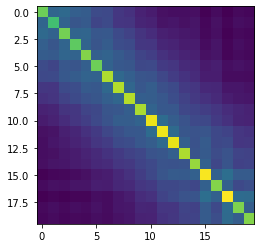

In [287]:
plt.imshow(New_Hessian)

In [289]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [290]:
cov_post = Laplace_appro(New_Hessian,cov_prior)

In [291]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float64)
    matrix2 = tf.cast(matrix2,tf.float64)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(constant64(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.add(negative_log_posterior(D,m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.add(negative_log_posterior(D,m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = constant64(0.9)

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float64)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    
    Xi = tfd.MultivariateNormalTriL(loc=0, scale_tril=tf.linalg.cholesky(cov_post))
    
#     Xi = tfd.MultivariateNormalFullCovariance(
#             loc = 0,
#             covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [295]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_gpCN = np.array(accepted)



Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Acceptance rate = 50.0%


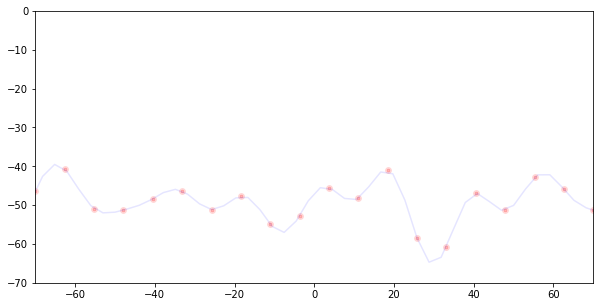

In [296]:
draw_MCMC(accepted_gpCN)

### try pCN MCMC

first define a likelihood function rather than posteior function

In [297]:
def log_likelihood(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_likelihood.log_prob(D))

def negative_likeli(_control_position):
    return tf.negative(log_likelihood(D,_control_position))

In [300]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(m_current)
    delta_proposed = negative_likeli(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [301]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_pCN = np.array(accepted)

Acceptance rate = 50.0%


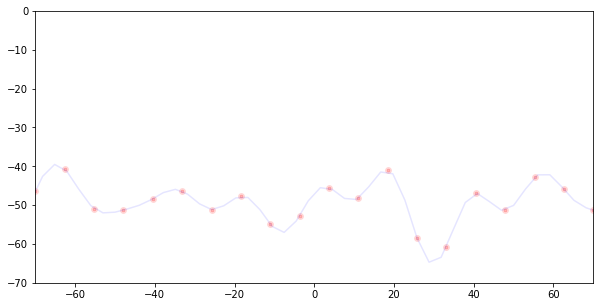

In [302]:
draw_MCMC(accepted_pCN)

In [ ]:
corner.corner(accepted_pCN)

In [ ]:
print('run success')